In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from sklearn.base import clone
import warnings



from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,f1_score,auc,ConfusionMatrixDisplay, roc_curve,roc_auc_score, precision_score,\
recall_score
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


C:\Users\mathi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\mathi\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Drop two first columns

In [4]:
df = df.drop(columns = ["id","day"])

Correlations between temperatures

In [5]:
df[["maxtemp","temparature","mintemp"]].corr()

,maxtemp,temparature,mintemp
maxtemp,1.000000,0.982932,0.965529
temparature,0.982932,1.000000,0.987150
mintemp,0.965529,0.987150,1.000000


Very high correlations, we drop minimum y maximum temperatures

In [6]:
df = df.drop(columns = ["maxtemp","mintemp"])

In [7]:
df[["dewpoint","temparature","humidity"]].corr()

,dewpoint,temparature,humidity
dewpoint,1.000000,0.933617,0.153390
temparature,0.933617,1.000000,-0.025016
humidity,0.153390,-0.025016,1.000000


Very high correlations between dewpoint and temperature

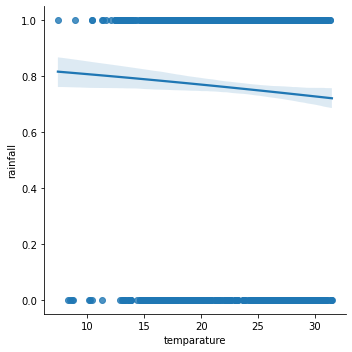

In [9]:
sns.lmplot(df , x = "temparature" , y = "rainfall" , logistic = True)

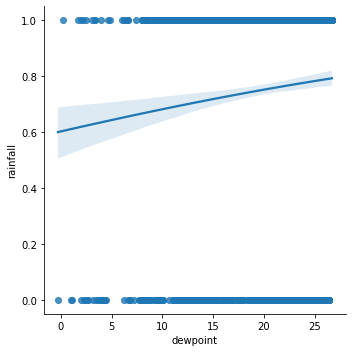

In [10]:
sns.lmplot(df , x = "dewpoint" , y = "rainfall" , logistic = True)

Temperature and dewpoint have no significant implications on probability of rainfall, mainely temperature

We know that condensation is more probable when temperature is small with respect to dewpoint, let us check this hypotesis.

In [11]:
df["diff_temp_dewpoint"] = df["temparature"] - df["dewpoint"]

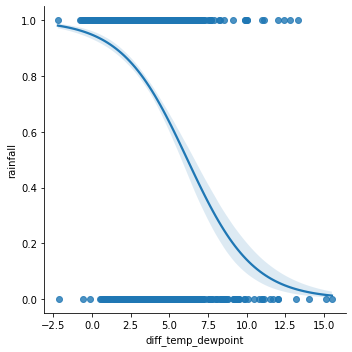

In [12]:
sns.lmplot(df,x = "diff_temp_dewpoint",y="rainfall",logistic = True)

Difference between temperature and dewpoint has a huge influence on probability of rainfall, we so drop temperature and dewpoint and keep the difference between them.

In [13]:
df = df.drop(columns = "dewpoint")

df = df.drop(columns = "temparature")

,pressure,humidity,cloud,sunshine,windspeed,rainfall
pressure,1.000000,-0.119949,0.098600,-0.257163,0.266012,-0.049886
humidity,-0.119949,1.000000,0.584854,-0.541592,0.062285,0.454213
cloud,0.098600,0.584854,1.000000,-0.805128,0.184698,0.641191
sunshine,-0.257163,-0.541592,-0.805128,1.000000,-0.241752,-0.555287
windspeed,0.266012,0.062285,0.184698,-0.241752,1.000000,0.111625
rainfall,-0.049886,0.454213,0.641191,-0.555287,0.111625,1.000000


Let us check the influence of winddirection on rainfall

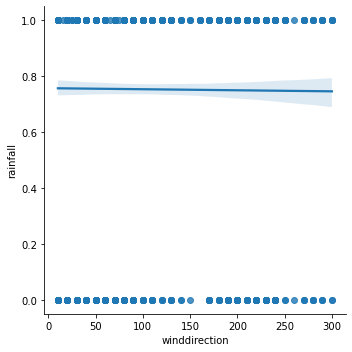

In [15]:
sns.lmplot(df,x="winddirection",y="rainfall",logistic=True)

We now check windspeed

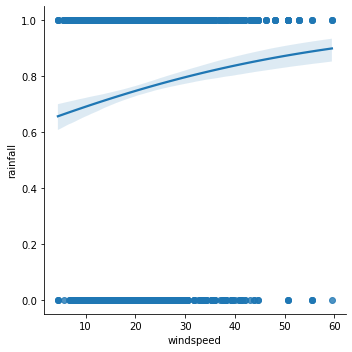

In [16]:
sns.lmplot(df,x="windspeed",y="rainfall",logistic=True)

It seems that windspeed has influence on rainfall but winddirection has no influence. We check with a Logistic Regression and Lasso regularization.

In [23]:
X.mean(axis = 0)

array([104.86315068,  21.8047032 ])

In [24]:
X = np.array(df[["winddirection","windspeed"]])
y = np.array(df["rainfall"]).reshape((-1,1))

X = (X - X.mean(axis = 0)) / X.std(axis = 0)

LR = LogisticRegression(penalty = "l1", solver =  "liblinear")

LR.fit(X,y)

C:\Users\mathi\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(penalty='l1', solver='liblinear')

In [25]:
LR.coef_

array([[0.03254799, 0.28031068]])

Efectivelly, winddirection has small influence of rainfall, so we drop it.

In [26]:
df = df.drop(columns = "winddirection")

We now study correlations between several variables.

In [28]:
df[["pressure","humidity","cloud","sunshine","windspeed","rainfall"]].corr()

,pressure,humidity,cloud,sunshine,windspeed,rainfall
pressure,1.000000,-0.119949,0.098600,-0.257163,0.266012,-0.049886
humidity,-0.119949,1.000000,0.584854,-0.541592,0.062285,0.454213
cloud,0.098600,0.584854,1.000000,-0.805128,0.184698,0.641191
sunshine,-0.257163,-0.541592,-0.805128,1.000000,-0.241752,-0.555287
windspeed,0.266012,0.062285,0.184698,-0.241752,1.000000,0.111625
rainfall,-0.049886,0.454213,0.641191,-0.555287,0.111625,1.000000


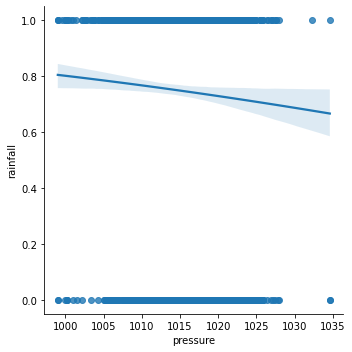

In [29]:
sns.lmplot(df,x="pressure",y="rainfall",logistic=True)

In [30]:
df = df.drop(columns = "pressure")

In [31]:
df.head()

,humidity,cloud,sunshine,windspeed,rainfall,diff_temp_dewpoint
0,87.0,88.0,1.1,17.2,1,1.2
1,95.0,91.0,0.0,21.9,1,1.5
2,75.0,47.0,8.3,18.1,1,6.8
3,95.0,95.0,0.0,35.6,1,1.0
4,52.0,45.0,3.6,24.8,0,8.8


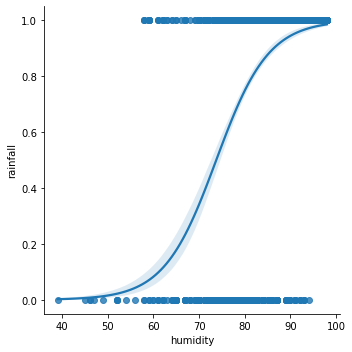

In [32]:
sns.lmplot(df,x = "humidity",y="rainfall",logistic = True)

In [33]:
df.head()

,humidity,cloud,sunshine,windspeed,rainfall,diff_temp_dewpoint
0,87.0,88.0,1.1,17.2,1,1.2
1,95.0,91.0,0.0,21.9,1,1.5
2,75.0,47.0,8.3,18.1,1,6.8
3,95.0,95.0,0.0,35.6,1,1.0
4,52.0,45.0,3.6,24.8,0,8.8


Supervised Learning

In [48]:
X = np.array(df[[col for col in df.columns if col != "rainfall"]])
y = np.array(df["rainfall"]).reshape((-1,1))

X = (X - X.mean(axis = 0)) / X.std(axis = 0)

In [52]:
# Class which makes a grid-seach with roc_auc_score

class GridSearchCV_auc_roc_curve:
    
    def __init__(self,estimator,param_grid,cv):
        
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.best_estimator = None
        self.all_scores = []
        all_parameters = product(*self.param_grid.values())
        self.all_estimators = [clone(estimator).set_params(**{key:value for key,value in zip(self.param_grid.keys(),parameters)})\
                              for parameters in all_parameters]
    
    def fit(self,X,y):
        df = pd.DataFrame(data = np.concatenate([X,y.reshape((-1,1))],axis = 1))
        kf = KFold(n_splits=self.cv)
        len_para_grid = len(self.param_grid)
        all_parameters = product(*self.param_grid.values())
        fited_estimators = []
        for parameters in all_parameters:
            auc_scores_list = []
            est = clone(self.estimator)
            est.set_params(**{key:value for key,value in zip(self.param_grid.keys(),parameters)})
            for train_idx, test_idx in kf.split(df):
                train = df.iloc[train_idx]
                test = df.iloc[test_idx]
                X_train = np.array(train.iloc[:,:-1])
                y_train = np.array(train.iloc[:,-1]).reshape((-1,))
                X_test = np.array(test.iloc[:,:-1])
                y_test = np.array(test.iloc[:,-1]).reshape((-1,))
                with warnings.catch_warnings():
                   warnings.simplefilter("ignore") 
                   est.fit(X_train,y_train)
                y_test_prob = est.predict_proba(X_test)
                if y_test_prob.ndim == 2 & y_test_prob.shape[1] == 2:
                    y_test_prob = y_test_prob[:,1].reshape((-1,1))
                else:
                    y_test_prob = y_test_prob.reshape((-1,1))
                auc_scores_list.append(roc_auc_score(y_test,y_test_prob))
            mean_auc_score = np.mean(auc_scores_list)
            self.all_scores.append(mean_auc_score)
            fited_estimators.append(est)
            
        idx_best_score = np.argmax(self.all_scores)
        self.best_score_ = self.all_scores[idx_best_score]
        self.best_estimator_ = fited_estimators[idx_best_score]

        
    def pred(self,X):
        
        if self.best_estimator == None:
            raise ValueError("You have not fit the model")
        else:
           return self.best_estimator.predict(X)
    
    def pred_prob(self,X):
        
        if self.best_estimator == None:
            raise ValueError("You have not fit the model")
        else:
           return self.best_estimator.predict_proba(X) 
        
        
        

In [53]:
#Function which compares different models

def models_grid_search_auc(data_model,X,y):
    

    metrics_models = []
    cols_dataset_metrics = ["auc_score"]




    best_estimators = dict()
    
    for model_name , model_info in data_model.items():
        print("**************************************************************************")
        print("*********************",model_name,"***************************************")
        print("**************************************************************************")
        model = model_info[0]
        param_grid = model_info[1]
        gs_model = GridSearchCV_auc_roc_curve(estimator = model , param_grid = param_grid , cv=5)
        gs_model.fit(X,y)
        best_estimator = gs_model.best_estimator_
        best_estimators.update({model_name:best_estimator})
        metrics_models.append(gs_model.best_score_)   
        
    metrics_models_df = pd.DataFrame(data = metrics_models,columns = ["AUC score"], index = data_model.keys())  

    return best_estimators,metrics_models_df

We compare, with differente hyper-parameters, Logistic Regression, KNeighborsClassifier and XGBOOST.

In [54]:
data_models = {'LR' : [LogisticRegression(max_iter = 1000),{'penalty': ['l2','none']
                                             , 'C': np.linspace(0.01, 5, 10)}]
              ,'knn' : [KNeighborsClassifier(),{'n_neighbors':[5,50,500]}]
#              ,'Random Forest' : [RandomForestClassifier(),{"n_estimators": [ 25, 100], 'max_depth': range(2, 11, 4)
#                                                            , 'min_samples_split': [2, 5, 10]}]
#               ,'Decision tree' : [DecisionTreeClassifier(),dict()]
              ,'XGBOOST' : [XGBClassifier(objective= 'binary:logistic'),{'max_depth': range (2, 10, 4),
     'n_estimators': range(60, 220, 70),
     'learning_rate': [0.1, 0.01, 0.05]}]}

In [55]:
best_estimators,metrics_models_df = models_grid_search_auc(data_models,X,y)

**************************************************************************
********************* LR ***************************************
**************************************************************************
**************************************************************************
********************* knn ***************************************
**************************************************************************
**************************************************************************
********************* XGBOOST ***************************************
**************************************************************************


In [56]:
metrics_models_df

,AUC score
LR,0.887979
knn,0.883662
XGBOOST,0.888271


XGBOOST wins!

In [57]:
classifier = best_estimators['XGBOOST']

In [71]:
test = pd.read_csv("test.csv")

In [72]:
test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [73]:
test.index = test.id

In [74]:
df.columns

Index(['humidity', 'cloud', 'sunshine', 'windspeed', 'rainfall',
       'diff_temp_dewpoint'],
      dtype='object')

In [75]:
test["diff_temp_dewpoint"] = test["temparature"] - test["dewpoint"]

In [76]:
test = test[[col for col in df.columns if col != "rainfall"]]

In [77]:
test.head()

,humidity,cloud,sunshine,windspeed,diff_temp_dewpoint
id,,,,,
2190,96.0,99.0,0.0,24.3,0.9
2191,97.0,99.0,0.0,35.3,1.4
2192,86.0,96.0,0.0,16.9,1.5
2193,75.0,45.0,7.1,50.6,7.8
2194,68.0,49.0,9.2,19.4,9.5


In [78]:
X_test = np.array(test)

In [79]:
X_test = (X_test - X_test.mean(axis = 0) ) / X_test.std(axis = 0)

In [80]:
test["prediction"] = classifier.predict_proba(X_test)[:,1]

In [81]:
test

,humidity,cloud,sunshine,windspeed,diff_temp_dewpoint,prediction
id,,,,,,
2190,96.0,99.0,0.0,24.3,0.9,0.952454
2191,97.0,99.0,0.0,35.3,1.4,0.952454
2192,86.0,96.0,0.0,16.9,1.5,0.945426
2193,75.0,45.0,7.1,50.6,7.8,0.260564
2194,68.0,49.0,9.2,19.4,9.5,0.166235
...,...,...,...,...,...,...
2915,96.0,95.0,0.0,34.3,3.9,0.952454
2916,78.0,80.0,1.6,25.2,2.1,0.803414
2917,92.0,96.0,0.0,21.9,3.0,0.952454


In [82]:
sample_submission = pd.read_csv("sample_submission.csv")

In [84]:
sample_submission.shape

(730, 2)

In [85]:
test.shape

(730, 6)

In [86]:
sample_submission.head()

,id,rainfall
0,2190,0
1,2191,0
2,2192,0
3,2193,0
4,2194,0


In [90]:
sample_submission.index = test.index

In [91]:
sample_submission["rainfall"] = test["prediction"]

In [93]:
sample_submission.index = range(len(test))

In [94]:
sample_submission

,id,rainfall
0,2190,0.952454
1,2191,0.952454
2,2192,0.945426
3,2193,0.260564
4,2194,0.166235
...,...,...
725,2915,0.952454
726,2916,0.803414
727,2917,0.952454
728,2918,0.952454


In [95]:
sample_submission.to_csv("sample_submission.csv")